In [2]:
import numpy as np
import pandas as pd
import warnings 
warnings.filterwarnings('ignore')
import seaborn as sns
from scipy.stats import zscore
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from scipy.stats import zscore
import statsmodels
import scipy.stats as stats
import statsmodels.stats.proportion as smpt
from sklearn import model_selection
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix,accuracy_score, classification_report,f1_score,cohen_kappa_score

In [3]:
d1=pd.read_csv('sample_data_intw.csv')

In [8]:
d1.head

<bound method NDFrame.head of         label       msisdn     aon  daily_decr30  daily_decr90  rental30  \
0           0  21408I70789   272.0   3055.050000   3065.150000    220.13   
1           1  76462I70374   712.0  12122.000000  12124.750000   3691.26   
2           1  17943I70372   535.0   1398.000000   1398.000000    900.13   
3           1  55773I70781   241.0     21.228000     21.228000    159.42   
4           1  03813I82730   947.0    150.619333    150.619333   1098.90   
...       ...          ...     ...           ...           ...       ...   
209588      1  22758I85348   404.0    151.872333    151.872333   1089.19   
209589      1  95583I84455  1075.0     36.936000     36.936000   1728.36   
209590      1  28556I85350  1013.0  11843.111670  11904.350000   5861.83   
209591      1  59712I82733  1732.0  12488.228330  12574.370000    411.83   
209592      1  65061I85339  1581.0   4489.362000   4534.820000    483.92   

        rental90  last_rech_date_ma  last_rech_date_da  l

In [4]:
d1.isnull().sum()

label                   0
msisdn                  0
aon                     0
daily_decr30            0
daily_decr90            0
rental30                0
rental90                0
last_rech_date_ma       0
last_rech_date_da       0
last_rech_amt_ma        0
cnt_ma_rech30           0
fr_ma_rech30            0
sumamnt_ma_rech30       0
medianamnt_ma_rech30    0
medianmarechprebal30    0
cnt_ma_rech90           0
fr_ma_rech90            0
sumamnt_ma_rech90       0
medianamnt_ma_rech90    0
medianmarechprebal90    0
cnt_da_rech30           0
fr_da_rech30            0
cnt_da_rech90           0
fr_da_rech90            0
cnt_loans30             0
amnt_loans30            0
maxamnt_loans30         0
medianamnt_loans30      0
cnt_loans90             0
amnt_loans90            0
maxamnt_loans90         0
medianamnt_loans90      0
payback30               0
payback90               0
pcircle                 0
pdate                   0
dtype: int64

In [5]:
d1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209593 entries, 0 to 209592
Data columns (total 36 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   label                 209593 non-null  int64  
 1   msisdn                209593 non-null  object 
 2   aon                   209593 non-null  float64
 3   daily_decr30          209593 non-null  float64
 4   daily_decr90          209593 non-null  float64
 5   rental30              209593 non-null  float64
 6   rental90              209593 non-null  float64
 7   last_rech_date_ma     209593 non-null  float64
 8   last_rech_date_da     209593 non-null  float64
 9   last_rech_amt_ma      209593 non-null  int64  
 10  cnt_ma_rech30         209593 non-null  int64  
 11  fr_ma_rech30          209593 non-null  float64
 12  sumamnt_ma_rech30     209593 non-null  float64
 13  medianamnt_ma_rech30  209593 non-null  float64
 14  medianmarechprebal30  209593 non-null  float64
 15  

## EDA Part

In [6]:
lst = [d1]
for column in lst:
    column.loc[column["rental30"] <= 0,  'balance_group'] = 'no balance'
    column.loc[(column["rental30"] > 0) & (column["rental30"] <= 19766), 'balance_group'] = 'low balance'
    column.loc[(column["rental30"] > 19766) & (column["rental30"] <= 118572), 'balance_group'] = 'average balance'
    column.loc[(column["rental30"] > 118572), 'balance_group'] = 'high balance'

In [7]:
count_balance_response_pct = pd.crosstab(d1['label'],d1['balance_group']).apply(lambda x: x/x.sum() * 100)
count_balance_response_pct = count_balance_response_pct.transpose()

In [9]:
count_balance_response_pct

label,0,1
balance_group,,
average balance,9.436834,90.563166
high balance,0.000000,100.000000
low balance,11.276328,88.723672
no balance,30.710929,69.289071


In [10]:
bal = pd.DataFrame(d1['balance_group'].value_counts())
#bal['% Contacted'] = bal['balance_group']*100/bal['balance_group'].sum()
bal['% Subscription'] = count_balance_response_pct[1]
bal.drop('balance_group',axis = 1,inplace = True)

bal['bal'] = [1,2,0,3]
bal = bal.sort_values('bal',ascending = True)

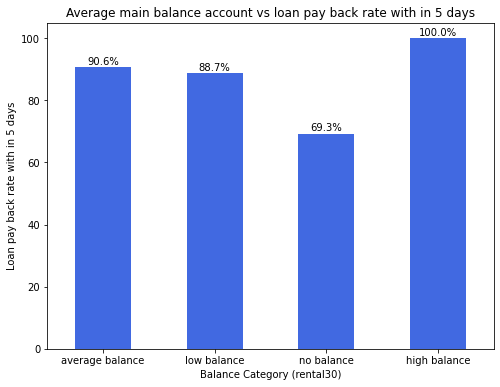

In [11]:
plot_balance = bal['% Subscription'].plot(kind = 'bar',
                                               color = ('royalblue'),
                                               figsize = (8,6))

plt.title('Average main balance account vs loan pay back rate with in 5 days')
plt.ylabel('Loan pay back rate with in 5 days')
plt.xlabel('Balance Category (rental30)')
plt.xticks(rotation = 'horizontal')

# label the bar
for rec, label in zip(plot_balance.patches,
                      bal['% Subscription'].round(1).astype(str)):
    plot_balance.text(rec.get_x() + rec.get_width()/2, 
                      rec.get_height() + 1, 
                      label+'%',  
                      ha = 'center', 
                      color = 'black')

## The above bar plot infers us how customers with different main balance levels are paying back the loan with in five days. 

### The high balance level people are with 100% rate i.e they are paying loan within 5 days. Coming to the average and low balance people it is observed that around 10%-12% of people are not paying the loan within 5 days.
### Coming to low balance level people, it is observed that around 30% of people are not paying back the loan with in stipulated 5 days of time. The 30% of people with no balance or negative balance people are creating a major loss to the company without paying back the loan within five days of time.
### In order to decrease loss to the company, the company should start some marketing strategies like sms alerting and notifications and others on the people with no balance, average and high balance level people notifying them to pay the loan back within five days of time.

In [12]:
lst = [d1]
for column in lst:
    column.loc[column["fr_ma_rech30"] <=0,  'frequency_group'] = 'no frequency'
    column.loc[(column['fr_ma_rech30'] > 0) & (column['fr_ma_rech30'] <=1 ), 'frequency_group'] = 'low frequency'
    column.loc[(column['fr_ma_rech30'] >1) & (column['fr_ma_rech30'] <=2), 'frequency_group'] = 'medium frequency'
    column.loc[(column['fr_ma_rech30'] >2), 'frequency_group'] = 'high frequency'

In [13]:
count_fre_response_pct = pd.crosstab(d1['label'],d1['frequency_group']).apply(lambda x: x/x.sum() * 100)
count_fre_response_pct = count_fre_response_pct.transpose()

In [14]:
fre = pd.DataFrame(d1['frequency_group'].value_counts())
#bal['% Contacted'] = bal['balance_group']*100/bal['balance_group'].sum()
fre['% Subscription'] = count_fre_response_pct[1]
fre.drop('frequency_group',axis = 1,inplace = True)

fre['fre'] = [1,2,0,3]
fre= fre.sort_values('fre',ascending = True)

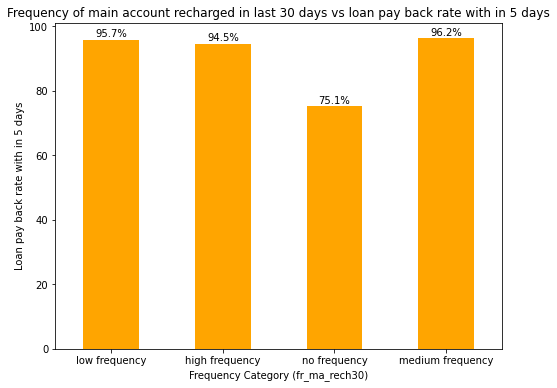

In [15]:
plot_fre = fre['% Subscription'].plot(kind = 'bar',
                                               color = ('orange'),
                                               figsize = (8,6))

plt.title('Frequency of main account recharged in last 30 days vs loan pay back rate with in 5 days')
plt.ylabel('Loan pay back rate with in 5 days')
plt.xlabel('Frequency Category (fr_ma_rech30)')
plt.xticks(rotation = 'horizontal')

# label the bar
for rec, label in zip(plot_fre.patches,
                      fre['% Subscription'].round(1).astype(str)):
    plot_fre.text(rec.get_x() + rec.get_width()/2, 
                      rec.get_height() + 1, 
                      label+'%',  
                      ha = 'center', 
                      color = 'black')

### The above bar plot infers us how customers with different frequency levels (main account recharge) are paying back the loan within five days. The is no 100% rate in any of the frequency levels to pay back the loan within 5 days. Coming to the average and low & medium frequency people it is observed that around 5%-6% of people are not paying the loan within 5 days.
### Coming to low frequency level people, it is observed that around 25% of people are not paying back the loan with in stipulated 5 days of time. The 25% people who are not getting their main account recharge for 30 days creating a major loss to the company without paying back the loan within five days of time.
### In order to decrease loss to the company, the company should start some marketing strategies like sms alerting and notifications and others on the people with all frequency levels and especially on no frequency level people notifying them to pay the loan back within five days of time.

In [16]:
lst = [d1]
for column in lst:
    column.loc[column["cnt_loans30"] <=0,  'loan_frequency_group'] = 'no loans'
    column.loc[(column['cnt_loans30'] > 0) & (column['cnt_loans30'] <=1 ), 'loan_frequency_group'] = 'low num of loans'
    column.loc[(column['cnt_loans30'] >1) & (column['cnt_loans30'] <=4), 'loan_frequency_group'] = 'medium num of loans'
    column.loc[(column['cnt_loans30'] >4), 'loan_frequency_group'] = 'high num of loans'

In [17]:
count_loan_response_pct = pd.crosstab(d1['label'],d1['loan_frequency_group']).apply(lambda x: x/x.sum() * 100)
count_loan_response_pct = count_loan_response_pct.transpose()

In [18]:
fre = pd.DataFrame(d1['loan_frequency_group'].value_counts())
#bal['% Contacted'] = bal['balance_group']*100/bal['balance_group'].sum()
fre['% Subscription'] = count_loan_response_pct[1]
fre.drop('loan_frequency_group',axis = 1,inplace = True)

fre['fre'] = [1,2,0,3]
fre= fre.sort_values('fre',ascending = True)

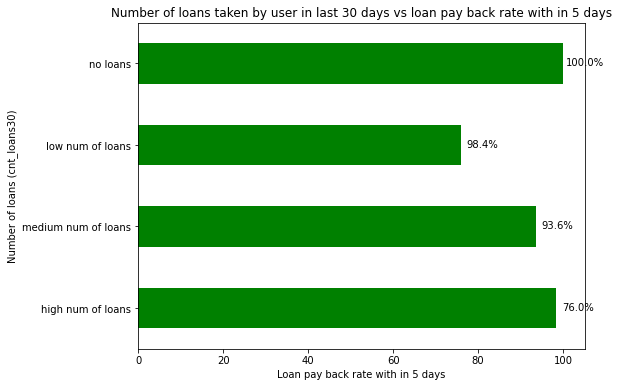

In [19]:
plot_fre = fre['% Subscription'].plot(kind = 'barh',
                                               color = ('green'), figsize = (8,6))

plt.title('Number of loans taken by user in last 30 days vs loan pay back rate with in 5 days')
plt.ylabel('Number of loans (cnt_loans30)')
plt.xlabel('Loan pay back rate with in 5 days')
plt.xticks(rotation = 'horizontal')

# label the bar
for rec, label in zip(plot_fre.patches,
                      fre['% Subscription'].round(1).sort_values(ascending = True).round(1).astype(str)):
    plot_fre.text(rec.get_width()+5, 
                  rec.get_y()+ rec.get_height()-0.3, 
                  label+'%', 
                  ha = 'center', 
                  va='bottom')

The above bar plot infers us how customers with different loans levels taken are paying back the loan within five days. In the data set people not taken loans are labelled as ‘1’. So we should not consider the people with no loans labelled in the above graph.
Considering the remaining levels, there is no 100% rate in any of the loan levels to pay back the loan within 5 days. Coming to the high number of loan level people it is observed that around 25% of people are not paying the loan within 5 days. Only 2% of the people from low number of loans category are not paying the loan within 5 days. This is followed by the people with medium number of loans having defaulters of 7% approximately.
In order to decrease loss to the company, the company should start some marketing strategies like sms alerting and notifications and others on the people with all loan levels and especially on low & high level people notifying them to pay the loan back within five days of time.

In [20]:
lst = [d1]
for column in lst:
    column.loc[column["amnt_loans30"] <=0,  'loanamnt_frequency_group'] = 'no loans'
    column.loc[(column['amnt_loans30'] > 0) & (column['amnt_loans30'] <=6 ), 'loanamnt_frequency_group'] = 'low amnt of loans'
    column.loc[(column['amnt_loans30'] >6) & (column['amnt_loans30'] <=24), 'loanamnt_frequency_group'] = 'medium amnt of loans'
    column.loc[(column['amnt_loans30'] >24), 'loanamnt_frequency_group'] = 'high amnt of loans'

In [21]:
count_loanamnt_response_pct = pd.crosstab(d1['label'],d1['loanamnt_frequency_group']).apply(lambda x: x/x.sum() * 100)
count_loanamnt_response_pct = count_loanamnt_response_pct.transpose()

In [22]:
fre1 = pd.DataFrame(d1['loanamnt_frequency_group'].value_counts())
#bal['% Contacted'] = bal['balance_group']*100/bal['balance_group'].sum()
fre1['% Subscription'] = count_loanamnt_response_pct[1]
fre1.drop('loanamnt_frequency_group',axis = 1,inplace = True)

fre1['fre1'] = [1,2,0,3]
fre1= fre1.sort_values('fre1',ascending = True)

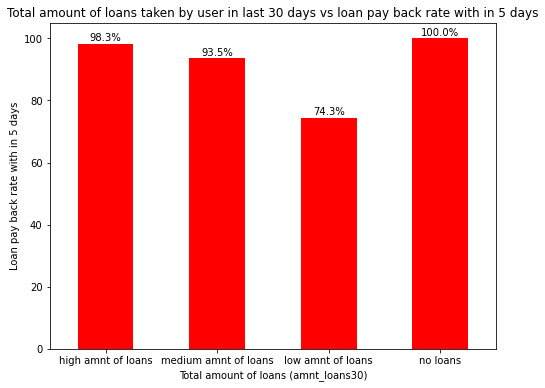

In [23]:
plot_fre1 = fre1['% Subscription'].plot(kind = 'bar',
                                               color = ('red'), figsize = (8,6))

plt.title('Total amount of loans taken by user in last 30 days vs loan pay back rate with in 5 days')
plt.ylabel('Loan pay back rate with in 5 days')
plt.xlabel('Total amount of loans (amnt_loans30)')
plt.xticks(rotation = 'horizontal')

# label the bar
for rec, label in zip(plot_fre1.patches,
                      fre1['% Subscription'].round(1).astype(str)):
    plot_fre1.text(rec.get_x() + rec.get_width()/2, 
                      rec.get_height() + 1, 
                      label+'%',  
                      ha = 'center', 
                      color = 'black')

The above bar plot infers us how customers with different loans levels taken are paying back the loan within five days. In the data set people not taken loans are labelled as ‘1’. So we should not consider the people with no loans labelled in the above graph.
Considering the remaining levels, there is no 100% rate in any of the loan levels to pay back the loan within 5 days. Coming to the low amount level people it is observed that around 25% of people are not paying the loan within 5 days. Only 2% of the people taken high amount of loans are not paying the loan within 5 days. This is followed by the people with medium number of loans having defaulters of 7% approximately.
In order to decrease loss to the company, the company should start some marketing strategies like sms alerting and notifications and others on the people with all loan levels and especially on low & high level people notifying them to pay the loan back within five days of time.
#### As 'msisdn', 'pcircle', 'pdate' features are not having much importance, we can ignore them. And also removing the extra columns created for the EDA part.

In [24]:
d1.drop(['msisdn', 'pcircle', 'pdate','balance_group','frequency_group','loan_frequency_group','loanamnt_frequency_group'],axis=1,inplace=True)
d1

,label,aon,daily_decr30,daily_decr90,rental30,rental90,last_rech_date_ma,last_rech_date_da,last_rech_amt_ma,cnt_ma_rech30,...,cnt_loans30,amnt_loans30,maxamnt_loans30,medianamnt_loans30,cnt_loans90,amnt_loans90,maxamnt_loans90,medianamnt_loans90,payback30,payback90
0,0,272.0,3055.050000,3065.150000,220.13,260.13,2.0,0.0,1539,2,...,2,12,6.0,0.0,2.0,12,6,0.0,29.000000,29.000000
1,1,712.0,12122.000000,12124.750000,3691.26,3691.26,20.0,0.0,5787,1,...,1,12,12.0,0.0,1.0,12,12,0.0,0.000000,0.000000
2,1,535.0,1398.000000,1398.000000,900.13,900.13,3.0,0.0,1539,1,...,1,6,6.0,0.0,1.0,6,6,0.0,0.000000,0.000000
3,1,241.0,21.228000,21.228000,159.42,159.42,41.0,0.0,947,0,...,2,12,6.0,0.0,2.0,12,6,0.0,0.000000,0.000000
4,1,947.0,150.619333,150.619333,1098.90,1098.90,4.0,0.0,2309,7,...,7,42,6.0,0.0,7.0,42,6,0.0,2.333333,2.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209588,1,404.0,151.872333,151.872333,1089.19,1089.19,1.0,0.0,4048,3,...,2,12,6.0,0.0,2.0,12,6,0.0,1.000000,1.000000
209589,1,1075.0,36.936000,36.936000,1728.36,1728.36,4.0,0.0,773,4,...,3,18,6.0,0.0,3.0,18,6,0.0,1.000000,1.000000
209590,1,1013.0,11843.111670,11904.350000,5861.83,8893.20,3.0,0.0,1539,5,...,4,42,12.0,0.0,6.0,54,12,0.0,4.000000,3.833333
209591,1,1732.0,12488.228330,12574.370000,411.83,984.58,2.0,38.0,773,5,...,2,18,12.0,0.0,3.0,24,12,0.0,0.000000,10.500000


In [ ]:
# Check for the correlation with the dependent variable 'Label

In [25]:
corr_data = d1
corr = corr_data.corr()
corr

,label,aon,daily_decr30,daily_decr90,rental30,rental90,last_rech_date_ma,last_rech_date_da,last_rech_amt_ma,cnt_ma_rech30,...,cnt_loans30,amnt_loans30,maxamnt_loans30,medianamnt_loans30,cnt_loans90,amnt_loans90,maxamnt_loans90,medianamnt_loans90,payback30,payback90
label,1.000000,-0.003785,0.168298,0.166150,0.058085,0.075521,0.003728,0.001711,0.131804,0.237331,...,0.196283,0.197272,0.000248,0.044589,0.004733,0.199788,0.084144,0.035747,0.048336,0.049183
aon,-0.003785,1.000000,0.001104,0.000374,-0.000960,-0.000790,0.001692,-0.001693,0.004256,-0.003148,...,-0.001826,-0.001726,-0.002764,0.004664,-0.000611,-0.002319,-0.001191,0.002771,0.001940,0.002203
daily_decr30,0.168298,0.001104,1.000000,0.977704,0.442066,0.458977,0.000487,-0.001636,0.275837,0.451385,...,0.366116,0.471492,-0.000028,-0.011610,0.008962,0.563496,0.400199,-0.037305,0.026915,0.047175
daily_decr90,0.166150,0.000374,0.977704,1.000000,0.434685,0.471730,0.000908,-0.001886,0.264131,0.426707,...,0.340387,0.447869,0.000025,-0.005591,0.009446,0.567204,0.397251,-0.034686,0.019400,0.040800
rental30,0.058085,-0.000960,0.442066,0.434685,1.000000,0.955237,-0.001095,0.003261,0.127271,0.233343,...,0.180203,0.233453,-0.000864,-0.016482,0.004012,0.298943,0.234211,-0.035489,0.072974,0.095147
rental90,0.075521,-0.000790,0.458977,0.471730,0.955237,1.000000,-0.001688,0.002794,0.121416,0.230260,...,0.171595,0.231906,-0.001411,-0.009467,0.005141,0.327436,0.251029,-0.034122,0.067110,0.099501
last_rech_date_ma,0.003728,0.001692,0.000487,0.000908,-0.001095,-0.001688,1.000000,0.001790,-0.000147,0.004311,...,0.001193,0.000903,0.000928,0.001835,-0.000225,0.000870,-0.001123,0.002771,-0.002233,-0.001583
last_rech_date_da,0.001711,-0.001693,-0.001636,-0.001886,0.003261,0.002794,0.001790,1.000000,-0.000149,0.001549,...,0.000380,0.000536,0.000503,0.000061,-0.000972,0.000519,0.001524,-0.002239,0.000077,0.000417
last_rech_amt_ma,0.131804,0.004256,0.275837,0.264131,0.127271,0.121416,-0.000147,-0.000149,1.000000,-0.002662,...,-0.027612,0.008502,0.001000,0.028370,0.000093,0.014067,0.148460,0.021004,-0.027369,-0.014260
cnt_ma_rech30,0.237331,-0.003148,0.451385,0.426707,0.233343,0.230260,0.004311,0.001549,-0.002662,1.000000,...,0.765802,0.752296,0.000109,-0.067011,0.014703,0.685257,0.174104,-0.071451,0.043617,0.017362


<AxesSubplot:>

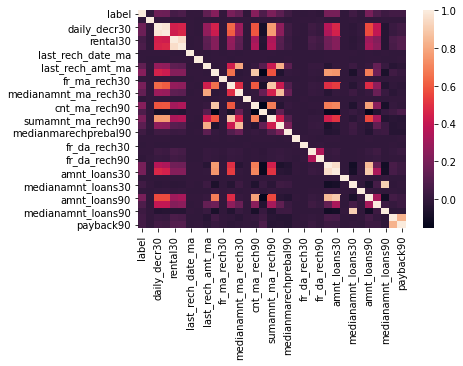

In [26]:
corr_data = d1
corr = corr_data.corr()
sns.heatmap(corr,annot_kws={'size':10})

In [27]:
d6=d1.copy()

In [28]:
d6.drop(['last_rech_date_da','fr_da_rech30','maxamnt_loans30','medianamnt_loans30','maxamnt_loans90','medianamnt_loans90','cnt_da_rech30','cnt_da_rech90','fr_da_rech90'],axis=1,inplace=True)

In [29]:
columns=d6.columns
columns

Index(['label', 'aon', 'daily_decr30', 'daily_decr90', 'rental30', 'rental90',
       'last_rech_date_ma', 'last_rech_amt_ma', 'cnt_ma_rech30',
       'fr_ma_rech30', 'sumamnt_ma_rech30', 'medianamnt_ma_rech30',
       'medianmarechprebal30', 'cnt_ma_rech90', 'fr_ma_rech90',
       'sumamnt_ma_rech90', 'medianamnt_ma_rech90', 'medianmarechprebal90',
       'cnt_loans30', 'amnt_loans30', 'cnt_loans90', 'amnt_loans90',
       'payback30', 'payback90'],
      dtype='object')

In [ ]:
# Checking the normality of the features

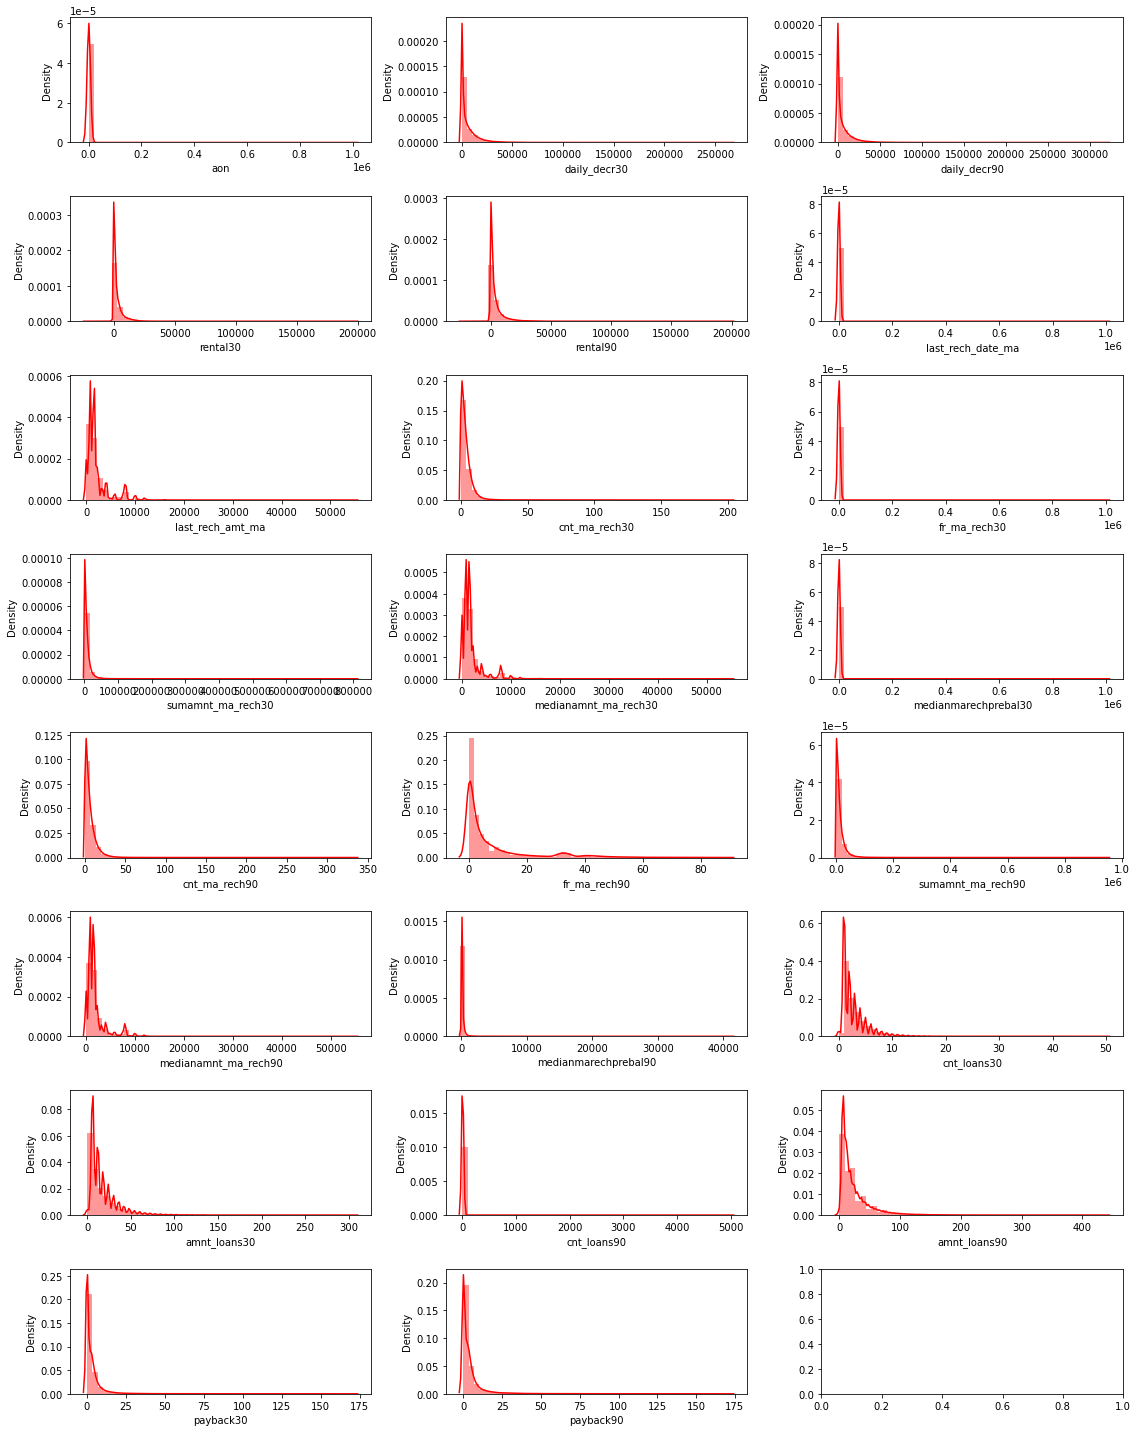

In [30]:
columns=['aon', 'daily_decr30', 'daily_decr90', 'rental30', 'rental90',
       'last_rech_date_ma', 'last_rech_amt_ma', 'cnt_ma_rech30',
       'fr_ma_rech30', 'sumamnt_ma_rech30', 'medianamnt_ma_rech30',
       'medianmarechprebal30', 'cnt_ma_rech90', 'fr_ma_rech90',
       'sumamnt_ma_rech90', 'medianamnt_ma_rech90', 'medianmarechprebal90',
       'cnt_loans30', 'amnt_loans30', 'cnt_loans90', 'amnt_loans90',
       'payback30', 'payback90']
fig,ax = plt.subplots(8,3,figsize=(16,20))
ax = ax.flatten()
for i,col in enumerate(columns):
    sns.distplot(d6[col],ax=ax[i],color='red')
plt.tight_layout()
plt.show()

In [31]:
d3=d1.copy()
d3

,label,aon,daily_decr30,daily_decr90,rental30,rental90,last_rech_date_ma,last_rech_date_da,last_rech_amt_ma,cnt_ma_rech30,...,cnt_loans30,amnt_loans30,maxamnt_loans30,medianamnt_loans30,cnt_loans90,amnt_loans90,maxamnt_loans90,medianamnt_loans90,payback30,payback90
0,0,272.0,3055.050000,3065.150000,220.13,260.13,2.0,0.0,1539,2,...,2,12,6.0,0.0,2.0,12,6,0.0,29.000000,29.000000
1,1,712.0,12122.000000,12124.750000,3691.26,3691.26,20.0,0.0,5787,1,...,1,12,12.0,0.0,1.0,12,12,0.0,0.000000,0.000000
2,1,535.0,1398.000000,1398.000000,900.13,900.13,3.0,0.0,1539,1,...,1,6,6.0,0.0,1.0,6,6,0.0,0.000000,0.000000
3,1,241.0,21.228000,21.228000,159.42,159.42,41.0,0.0,947,0,...,2,12,6.0,0.0,2.0,12,6,0.0,0.000000,0.000000
4,1,947.0,150.619333,150.619333,1098.90,1098.90,4.0,0.0,2309,7,...,7,42,6.0,0.0,7.0,42,6,0.0,2.333333,2.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209588,1,404.0,151.872333,151.872333,1089.19,1089.19,1.0,0.0,4048,3,...,2,12,6.0,0.0,2.0,12,6,0.0,1.000000,1.000000
209589,1,1075.0,36.936000,36.936000,1728.36,1728.36,4.0,0.0,773,4,...,3,18,6.0,0.0,3.0,18,6,0.0,1.000000,1.000000
209590,1,1013.0,11843.111670,11904.350000,5861.83,8893.20,3.0,0.0,1539,5,...,4,42,12.0,0.0,6.0,54,12,0.0,4.000000,3.833333
209591,1,1732.0,12488.228330,12574.370000,411.83,984.58,2.0,38.0,773,5,...,2,18,12.0,0.0,3.0,24,12,0.0,0.000000,10.500000


#### Outlier Transformation:
Several changes were made to the dataset to prepare it for analysis. As there are no null values in the data set there is no need to perform any null value imputation for the data set. There are outliers for many variables in the data set.
By observing these features, I found way of doing an outlier’s imputation technique for the data of the features whose z-score >3. There are many ways to deal with outliers such as imputing outlier’s with mean, median, mode (categorical), k-NN imputation, mice imputation or simply removing and others.
For this data set I simply choose mean for imputing the outliers with the respective features. After performing mean, I also applied cube root for the data to bring data closer as to make the distribution normal.
After performing the mean imputation and also applying cube root to the data become so what normally distributed compared to the data which haven’t undergone any type of imputation or outlier transformation.
So, outlier imputation is far better than simply removing the outliers from the data. As the data set belongs to the loan defaulters or not the outliers are also important for us to get the unbiased results after performing machine learning algorithms.

In [32]:
columns=['aon', 'daily_decr30', 'daily_decr90', 'rental30', 'rental90',
       'last_rech_date_ma', 'last_rech_date_da', 'last_rech_amt_ma',
       'cnt_ma_rech30', 'fr_ma_rech30', 'sumamnt_ma_rech30',
       'medianamnt_ma_rech30', 'medianmarechprebal30', 'cnt_ma_rech90',
       'fr_ma_rech90', 'sumamnt_ma_rech90', 'medianamnt_ma_rech90',
       'medianmarechprebal90', 'cnt_da_rech30', 'fr_da_rech30',
       'cnt_da_rech90', 'fr_da_rech90', 'cnt_loans30', 'amnt_loans30',
       'maxamnt_loans30', 'medianamnt_loans30', 'cnt_loans90', 'amnt_loans90',
       'maxamnt_loans90', 'medianamnt_loans90', 'payback30', 'payback90']
for i in range(len(columns)):
    d3[columns[i]]=zscore(d3[columns[i]])
    for j in range(len(d3[columns[i]])):
        if d3[columns[i]][j]>3 or d3[columns[i]][j]<-3:
            d3[columns[i]].replace(d3[columns[i]][j],d3[columns[i]].median(),inplace=True)
    d3[columns[i]]=np.cbrt((d3[columns[i]]))

In [34]:
d3.head

<bound method NDFrame.head of         label       aon  daily_decr30  daily_decr90  rental30  rental90  \
0           0 -0.469628     -0.631886     -0.651355 -0.830994 -0.823561   
1           1 -0.460673      0.900837      0.820996  0.614277  0.330255   
2           1 -0.464317     -0.755959     -0.754218 -0.746514 -0.764987   
3           1 -0.470246     -0.834590     -0.821858 -0.837741 -0.832051   
4           1 -0.455745     -0.827820     -0.815968 -0.717832 -0.744840   
...       ...       ...           ...           ...       ...       ...   
209588      1 -0.466978     -0.827754     -0.815910 -0.719287 -0.745850   
209589      1 -0.453015     -0.833774     -0.821147 -0.607129 -0.672501   
209590      1 -0.454341      0.888238      0.810890  0.902695  0.978717   
209591      1 -0.438454      0.916865      0.840875 -0.808937 -0.756558   
209592      1 -0.441886     -0.459066     -0.521399 -0.800323 -0.790661   

        last_rech_date_ma  last_rech_date_da  last_rech_amt_ma  cnt_m

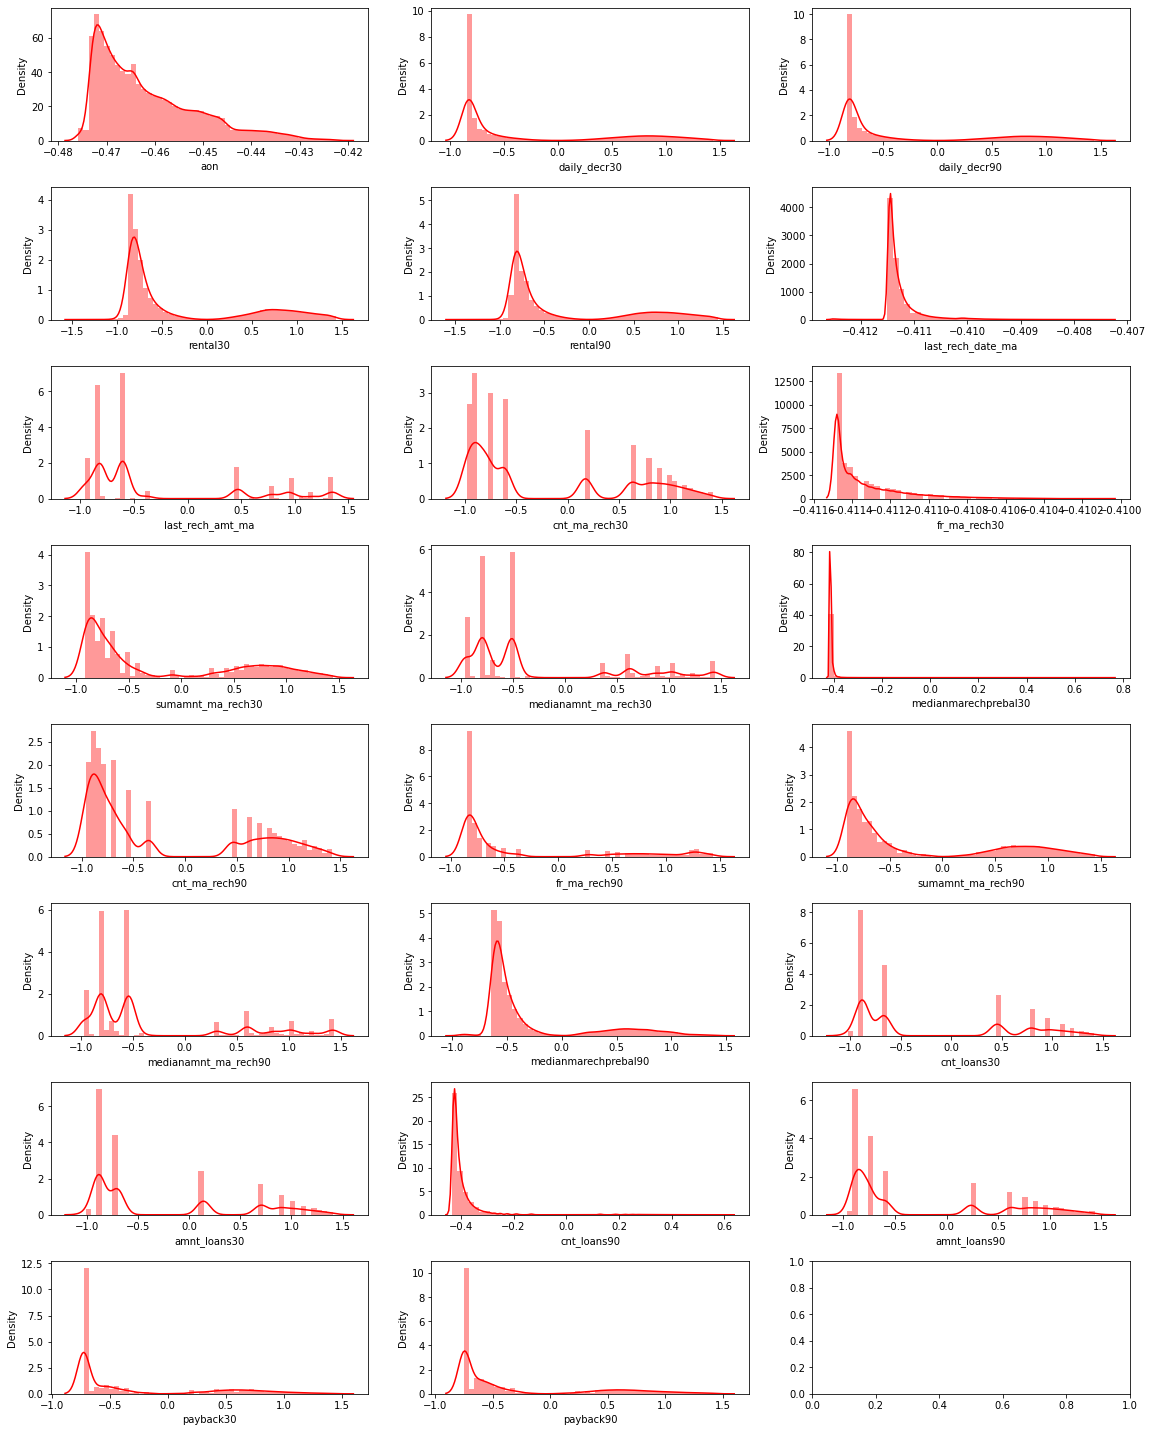

In [35]:
columns=['aon', 'daily_decr30', 'daily_decr90', 'rental30', 'rental90',
       'last_rech_date_ma', 'last_rech_amt_ma', 'cnt_ma_rech30',
       'fr_ma_rech30', 'sumamnt_ma_rech30', 'medianamnt_ma_rech30',
       'medianmarechprebal30', 'cnt_ma_rech90', 'fr_ma_rech90',
       'sumamnt_ma_rech90', 'medianamnt_ma_rech90', 'medianmarechprebal90',
       'cnt_loans30', 'amnt_loans30', 'cnt_loans90', 'amnt_loans90',
       'payback30', 'payback90']
fig,ax = plt.subplots(8,3,figsize=(16,20))
ax = ax.flatten()
for i,col in enumerate(columns):
    sns.distplot(d3[col],ax=ax[i],color='red')
plt.tight_layout()
plt.show()

In [36]:
d3.drop(['label'],axis=1,inplace=True)

In [ ]:
# Statistical Analysis

In [37]:
def two_sample_ttest(target_variable, numerical_column):
    reject = []
    not_reject = []
    print('H0: The mean of ' + numerical_column.name + ' is equal for both categories of ' + target_variable.name)
    print('Ha: The mean of ' + numerical_column.name + ' is NOT equal for both categories of ' + target_variable.name)
    print()
    grp0 = numerical_column[target_variable == 0]
    grp1 = numerical_column[target_variable == 1]
    ttest = stats.ttest_ind(grp0, grp1)
    print(ttest)
    rejectH0 = ttest[1] < 0.05
    print()
    #return rejectH0
    if rejectH0:
        print('Reject H0')
        reject.append(col)
        print('\n')
        print('-------------------------------------------------------------------------')
    else:
        print('Failed to Reject H0')   
        not_reject.append(col)
        print()
        print('-------------------------------------------------------------------------')

In [38]:
num_cols = ['aon', 'daily_decr30', 'daily_decr90', 'rental30', 'rental90',
       'last_rech_date_ma', 'last_rech_date_da', 'last_rech_amt_ma',
       'cnt_ma_rech30', 'fr_ma_rech30', 'sumamnt_ma_rech30',
       'medianamnt_ma_rech30', 'medianmarechprebal30', 'cnt_ma_rech90',
       'fr_ma_rech90', 'sumamnt_ma_rech90', 'medianamnt_ma_rech90',
       'medianmarechprebal90', 'cnt_da_rech30', 'fr_da_rech30',
       'cnt_da_rech90', 'fr_da_rech90', 'cnt_loans30', 'amnt_loans30',
       'maxamnt_loans30', 'medianamnt_loans30', 'cnt_loans90', 'amnt_loans90',
       'maxamnt_loans90', 'medianamnt_loans90', 'payback30', 'payback90']

#reject = []
#not_reject = []
for col in num_cols:
    rejectH0 = two_sample_ttest(d1['label'], d3[col])

H0: The mean of aon is equal for both categories of label
Ha: The mean of aon is NOT equal for both categories of label

Ttest_indResult(statistic=-35.67290016771915, pvalue=7.146659628197667e-278)

Reject H0


-------------------------------------------------------------------------
H0: The mean of daily_decr30 is equal for both categories of label
Ha: The mean of daily_decr30 is NOT equal for both categories of label

Ttest_indResult(statistic=-95.92326407301246, pvalue=0.0)

Reject H0


-------------------------------------------------------------------------
H0: The mean of daily_decr90 is equal for both categories of label
Ha: The mean of daily_decr90 is NOT equal for both categories of label

Ttest_indResult(statistic=-95.84733435014256, pvalue=0.0)

Reject H0


-------------------------------------------------------------------------
H0: The mean of rental30 is equal for both categories of label
Ha: The mean of rental30 is NOT equal for both categories of label

Ttest_indResult(

In [39]:
X1=d3

### VIF

In [40]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif= pd.DataFrame()
vif['Features'] = d3.columns
vif['vif']=[variance_inflation_factor(d3.values,i) for i in range(d3.shape[1])]
vif[vif['vif']>4]

,Features,vif
0,aon,1.964279e+03
1,daily_decr30,1.249489e+01
2,daily_decr90,1.301443e+01
3,rental30,6.177588e+00
4,rental90,6.725150e+00
5,last_rech_date_ma,1.738138e+06
6,last_rech_date_da,4.392088e+06
8,cnt_ma_rech30,4.512458e+00
9,fr_ma_rech30,6.074839e+06
10,sumamnt_ma_rech30,4.333607e+00


From the above results we can infer that the many features are having strong multicollinearity in the data set. This resembles that there is need to go for PCA (Principal Component Analysis).
If we won’t perform PCA the noise or correlation between the independent variables will affect the model prediction and model results. More than 50% of the features are having vif >4 so it is mandatory to perform PCA in order to reduce the multicollinearity effect among the independent variables.

### PCA

In [41]:
from sklearn.decomposition import PCA
pca=PCA()
pca.fit(d3)
data_pca= pca.transform(d3)

In [42]:
cumsum=np.cumsum(pca.explained_variance_ratio_)
cumsum

array([0.36391966, 0.52144892, 0.61602579, 0.69386225, 0.74559359,
       0.78850652, 0.82671891, 0.8573575 , 0.88059873, 0.90160426,
       0.91891882, 0.93554025, 0.94951119, 0.95907565, 0.96661809,
       0.97358484, 0.97978258, 0.98574356, 0.99077737, 0.99398195,
       0.99656523, 0.9990396 , 0.99956725, 0.99970611, 0.99982433,
       0.99993338, 0.9999894 , 0.99999998, 0.99999999, 1.        ,
       1.        , 1.        ])

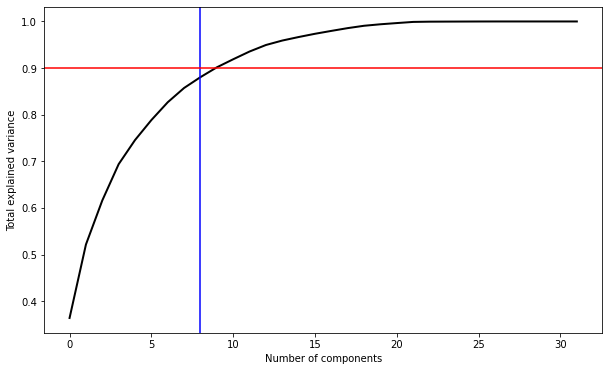

In [43]:
plt.figure(figsize=(10,6))

plt.plot(range(0,32), cumsum, color='k', lw=2)

plt.xlabel('Number of components')
plt.ylabel('Total explained variance')

plt.axvline(8, c='b')
plt.axhline(0.9, c='r')

plt.show()

In [44]:
cov_matrix = np.cov(d3.T)
print('Covariance Matrix \n%s', cov_matrix)

Covariance Matrix 
%s [[ 1.10530498e-04  5.96454189e-04  5.75228095e-04 ... -4.78234527e-06
   1.28083927e-04  2.12521954e-04]
 [ 5.96454189e-04  5.63641611e-01  5.24437527e-01 ... -5.15869914e-03
   8.82617731e-02  8.98069755e-02]
 [ 5.75228095e-04  5.24437527e-01  5.39783777e-01 ... -5.05175907e-03
   8.23727485e-02  8.66554290e-02]
 ...
 [-4.78234527e-06 -5.15869914e-03 -5.05175907e-03 ...  9.75001146e-02
  -2.13322228e-03  1.83662697e-03]
 [ 1.28083927e-04  8.82617731e-02  8.23727485e-02 ... -2.13322228e-03
   3.82551451e-01  3.02046363e-01]
 [ 2.12521954e-04  8.98069755e-02  8.66554290e-02 ...  1.83662697e-03
   3.02046363e-01  3.81340038e-01]]


In [45]:
eig_vals, eig_vecs = np.linalg.eig(cov_matrix)
eigen_pairs = [(np.abs(eig_vals[i]), eig_vecs[ :, i]) for i in range(len(eig_vals))]

In [46]:
tot = sum(eig_vals)
var_exp = [( i /tot ) * 100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print("Cumulative Variance Explained", cum_var_exp)

Cumulative Variance Explained [ 36.3919656   52.14489233  61.60257885  69.38622504  74.55935929
  78.85065208  82.67189093  85.73574993  88.05987331  90.16042587
  91.89188187  93.55402535  94.95111868  95.90756548  96.66180918
  97.35848436  97.97825841  98.57435551  99.07773656  99.39819526
  99.65652321  99.90395993  99.95672484  99.97061126  99.98243319
  99.99333796  99.99894003  99.99999839  99.99999935  99.99999973
 100.         100.        ]


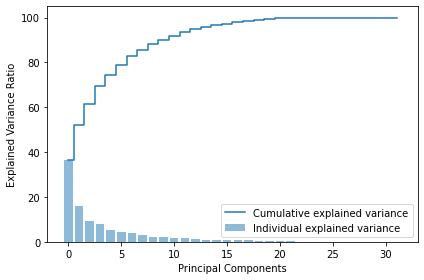

In [47]:
plt.figure(figsize=(6 , 4))
plt.bar(range(32), var_exp, alpha = 0.5, align = 'center', label = 'Individual explained variance')
plt.step(range(32), cum_var_exp, where='mid', label = 'Cumulative explained variance')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

From the above results it is observed that 90% of the data is covered at the pca components (n=13). So total number of pca components were taken as 13.

In [48]:
pca = PCA(n_components=13)
pca.fit(d3)
data_pca = pd.DataFrame(pca.transform(d3))
data_pca.shape

(209593, 13)

In [81]:
data_pca

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,-1.317369,-0.478951,-0.575454,2.397262,-0.935696,0.188606,-0.792507,0.938883,-0.284819,0.091649,-0.217451,-0.054349,-0.005137
1,0.376630,3.205119,1.223947,0.313108,0.047349,-1.768409,0.886548,-0.082874,0.123731,-0.684481,-0.258148,0.681419,0.158124
2,-2.013359,-0.059871,0.169447,-0.469874,0.009245,-0.392086,-0.016005,-0.185076,-0.060666,0.023243,-0.041141,-0.023359,0.065832
3,-2.059540,-0.608705,0.155077,-0.449883,-0.051500,-0.396079,0.156880,-0.306729,-0.253967,0.066931,0.007668,-0.077045,-0.081890
4,2.328159,0.264414,-2.431849,-0.996839,1.064115,0.085948,0.048846,-0.241062,-0.547807,-0.032977,0.137404,-0.308970,0.178096
...,...,...,...,...,...,...,...,...,...,...,...,...,...
209588,-0.778444,2.034025,-1.207943,-0.600083,0.705766,-0.381810,-0.383350,0.082498,-0.169439,0.219733,-0.135284,0.173737,-0.101451
209589,-0.653783,-1.199493,-0.430239,-0.563887,0.469779,0.044971,0.371035,-0.202918,0.768340,0.224642,-0.237312,0.436766,0.076155
209590,3.750996,-0.577959,1.239195,0.189288,-0.006415,-0.424833,1.098336,0.391034,-0.321864,0.060853,-0.015298,-0.088891,0.050225
209591,1.770430,0.504857,0.214961,-0.519012,-1.784762,-0.774547,0.515795,1.187945,0.099475,0.715087,-0.237547,0.202301,0.584062


In [82]:
d1['label']

0         0
1         1
2         1
3         1
4         1
         ..
209588    1
209589    1
209590    1
209591    1
209592    1
Name: label, Length: 209593, dtype: int64

In [49]:
X1=data_pca
y1=d1['label']

In [50]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.3, random_state=1)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(146715, 13)
(62878, 13)
(146715,)
(62878,)


### Logistic regression

In [51]:
from sklearn.linear_model import LogisticRegression
model1 = LogisticRegression()
model1.fit(X_train, y_train)

LogisticRegression()

In [52]:
print('Training score =', model1.score(X_train, y_train))
print('Test score =', model1.score(X_test, y_test))

Training score = 0.8764475343352759
Test score = 0.8783358249308184


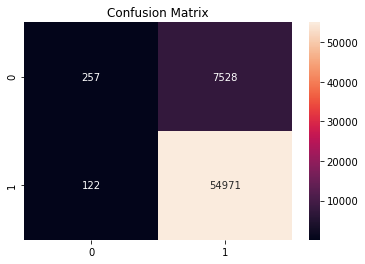

In [53]:
from sklearn.metrics import confusion_matrix
ypred = model1.predict(X_test)
cm = confusion_matrix(y_test, ypred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.show()

In [54]:
tn = cm[0,0]  #True Negative
tp = cm[1,1]  #True Positives
fp = cm[0,1]  #False Positives
fn = cm[1,0]  #False Negatives

accuracy = (tp+tn)/(tp+fn+fp+tn)
precision = tp / (tp+fp)
recall = tp / (tp+fn)
f1 = 2*precision*recall / (precision+recall)

print('Accuracy =',accuracy)
print('Precision =', precision)
print('Recall =', recall)
print('F1 Score =', f1)

Accuracy = 0.8783358249308184
Precision = 0.8795500728011648
Recall = 0.997785562594159
F1 Score = 0.934944554051296


ROC AUC = 0.8298788464197999


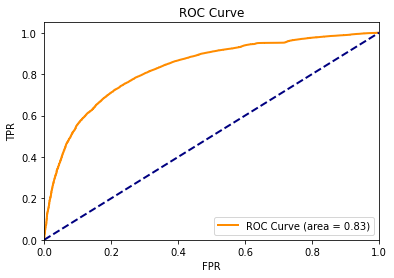

In [55]:
from sklearn.metrics import roc_curve,roc_auc_score
ypred = model1.predict_proba(X_test)
fpr,tpr,threshold = roc_curve(y_test,ypred[:,1])
roc_auc = roc_auc_score(y_test,ypred[:,1])

print('ROC AUC =', roc_auc)
plt.figure()
lw = 2
plt.plot(fpr,tpr,color='darkorange',lw=lw,label='ROC Curve (area = %0.2f)'%roc_auc)
plt.plot([0,1],[0,1],color='navy',lw=lw,linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

From the above results it is observed that all the metrics accuracy, precision, recall and f1-score are good. In order to improve the score very much high I also tried with various other models such as decision tree, random forest, naïve bays, knn, and ensemble models also.
Four different classification algorithms (Logistic Regression, K-Neighbours Classifier, Decision Tree Classifier, and Gaussian NB, Random Forest, Ada boost, Gradient Boosting) were run on the dataset through K-fold cross validation and the best-performing one was (identified by observing bias and variance errors) and used to build the classification model.

In [56]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,AdaBoostClassifier,GradientBoostingClassifier

### KNN

In [57]:
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
knn=KNeighborsClassifier()
param={'n_neighbors':np.arange(5,30),'weights':['uniform','distance']}
GS=RandomizedSearchCV(knn,param,cv=3,scoring='f1_weighted',n_jobs=-1)
GS.fit(X_train,y_train)

RandomizedSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
                   param_distributions={'n_neighbors': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 23, 24, 25, 26, 27, 28, 29]),
                                        'weights': ['uniform', 'distance']},
                   scoring='f1_weighted')

In [58]:
GS.best_params_

{'weights': 'distance', 'n_neighbors': 27}

### Decision Tree

In [59]:
dt=DecisionTreeClassifier(random_state=0)
param={'max_depth':np.arange(3,50),'criterion':['entropy','gini'],'min_samples_leaf':np.arange(3,20)}
GS=RandomizedSearchCV(dt,param,cv=3,scoring='f1_weighted')
GS.fit(X_train,y_train)
GS.best_params_

{'min_samples_leaf': 8, 'max_depth': 11, 'criterion': 'entropy'}

In [60]:
LR=LogisticRegression()
NB=GaussianNB()
KNN=KNeighborsClassifier(n_neighbors=5,weights='distance')
DT=DecisionTreeClassifier(criterion='entropy',max_depth=11,min_samples_leaf=8,random_state=0)
RF=RandomForestClassifier(criterion='entropy',n_estimators=7,random_state=0)
Bag=BaggingClassifier(n_estimators=3,random_state=0)
AB=AdaBoostClassifier(n_estimators=16,random_state=0)
#ABL=AdaBoostClassifier(base_estimator=LR,n_estimators=50,random_state=0)
GB=GradientBoostingClassifier(n_estimators=17)

### Random Forest

In [61]:
RF_var=[]
for val in np.arange(1,50):
  RF=RandomForestClassifier(criterion='entropy',n_estimators=val,random_state=0)
  kfold = model_selection.KFold(shuffle=True,n_splits=3,random_state=0)
  cv_results = model_selection.cross_val_score(RF, X_train,y_train,cv=kfold, scoring='f1_weighted',n_jobs=-1)
  RF_var.append(np.var(cv_results,ddof=1))

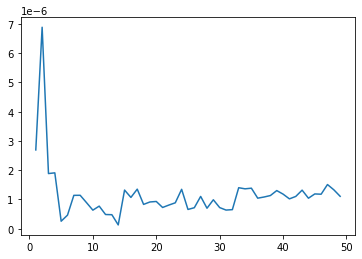

In [62]:
x_axis=np.arange(1,50)
plt.plot(x_axis,RF_var)

In [ ]:
# To get n-estimators

In [63]:
np.argmin(RF_var)

13

In [64]:
Bag_var=[]
for val in np.arange(1,20):
  Bag=BaggingClassifier(n_estimators=val,random_state=0)
  kfold = model_selection.KFold(shuffle=True,n_splits=3,random_state=0)
  cv_results = model_selection.cross_val_score(Bag, X_train,y_train,cv=kfold, scoring='f1_weighted',n_jobs=-1)
  Bag_var.append(np.var(cv_results,ddof=1))

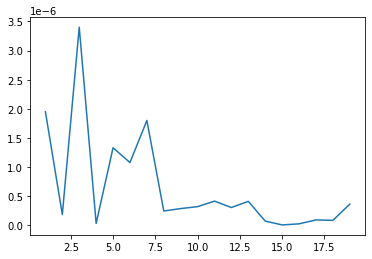

In [65]:
x_axis=np.arange(1,20)
plt.plot(x_axis,Bag_var)

In [66]:
np.argmin(Bag_var)

14

### Ada Boost Classifier

In [67]:
Ada_bias=[]
for val in np.arange(1,20):
  Ada=AdaBoostClassifier(n_estimators=val,random_state=0)
  kfold = model_selection.KFold(shuffle=True,n_splits=3,random_state=0)
  cv_results = model_selection.cross_val_score(Ada, X_train, y_train,cv=kfold, scoring='f1_weighted',n_jobs=-1)
  Ada_bias.append(1-np.mean(cv_results))

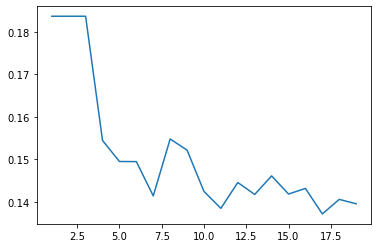

In [68]:
x_axis=np.arange(1,20)
plt.plot(x_axis,Ada_bias)

In [69]:
np.argmin(Ada_bias)

16

### Gradient Boost Clsssifier

In [70]:
GB_bias=[]
for val in np.arange(1,20):
  gb=GradientBoostingClassifier(n_estimators=val)
  kfold = model_selection.KFold(shuffle=True,n_splits=3,random_state=0)
  cv_results = model_selection.cross_val_score(gb, X_train, y_train,cv=kfold, scoring='f1_weighted',n_jobs=-1)
  GB_bias.append(1-np.mean(cv_results))

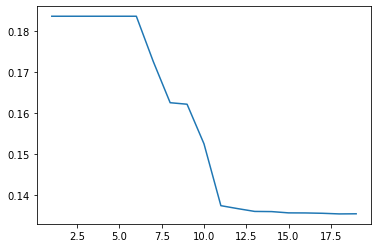

In [71]:
x_axis=np.arange(1,20)
plt.plot(x_axis,GB_bias)

In [72]:
np.argmin(GB_bias)

17

In [73]:
models = []
models.append(('Logistic', LR))
models.append(('NaiveBayes', NB))
models.append(('KNN',KNN))
models.append(('DecisionTree',DT))
models.append(('RandomForest',RF))
models.append(('BaggingClassifier',Bag))
models.append(('AdaBoost',AB))
models.append(('GBoost',GB))

### evaluate each model in turn

Logistic: 0.824303 (0.000007)
NaiveBayes: 0.810621 (0.000002)
KNN: 0.877999 (0.000003)
DecisionTree: 0.880598 (0.000004)
RandomForest: 0.885312 (0.000001)
BaggingClassifier: 0.884375 (0.000000)
AdaBoost: 0.856886 (0.000136)
GBoost: 0.864559 (0.000001)


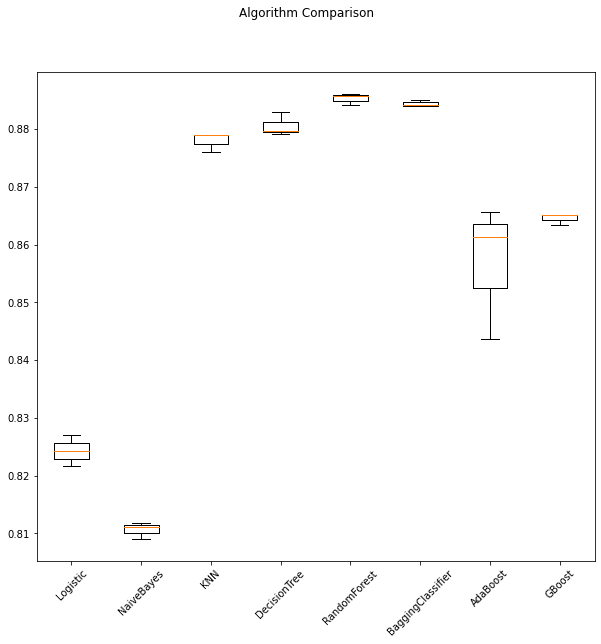

In [74]:
results = []
names = []
for name, model in models:
	kfold = model_selection.KFold(shuffle=True,n_splits=3,random_state=0)
	cv_results = model_selection.cross_val_score(model, X_train, y_train,cv=kfold, scoring='f1_weighted',n_jobs=-1)
	results.append(cv_results)
	names.append(name)
	print("%s: %f (%f)" % (name, np.mean(cv_results),np.var(cv_results,ddof=1)))
   # boxplot algorithm comparison
fig = plt.figure(figsize=(10,9))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names,rotation=45)
plt.show()

From the above results it is observed that Random Forest is the best performing model. By comparing all algorithms bias error and variance error, random forest is observed to be the best so it would be used to predict loan defaulters. The test of random forest with base estimator (Decision Tree (which is default for random forest), n_estimators=7) model successfully achieved a weighted F1_score of 98%, suggesting high level of strength of this model to classify loan defaulter’s.

In [ ]:
### Random Forest

In [75]:
RF.fit(X_train,y_train)

RandomForestClassifier(criterion='entropy', n_estimators=49, random_state=0)

In [76]:
predictions = RF.predict(X_test)

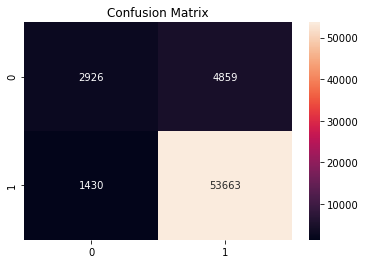

In [77]:
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.show()

In [78]:
# Classification Report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.67      0.38      0.48      7785
           1       0.92      0.97      0.94     55093

    accuracy                           0.90     62878
   macro avg       0.79      0.67      0.71     62878
weighted avg       0.89      0.90      0.89     62878



In [79]:
tn = cm[0,0]  #True Negative
tp = cm[1,1]  #True Positives
fp = cm[0,1]  #False Positives
fn = cm[1,0]  #False Negatives

accuracy = (tp+tn)/(tp+fn+fp+tn)
precision = tp / (tp+fp)
recall = tp / (tp+fn)
f1 = 2*precision*recall / (precision+recall)

print('Accuracy =',accuracy)
print('Precision =', precision)
print('Recall =', recall)
print('F1 Score =', f1)

Accuracy = 0.8999809154235185
Precision = 0.9169713953726804
Recall = 0.9740438894233387
F1 Score = 0.9446463935219822


ROC AUC = 0.8403844630042916


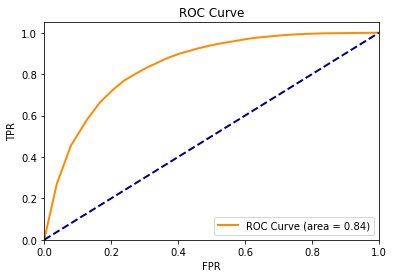

In [80]:
from sklearn.metrics import roc_curve,roc_auc_score
ypred = RF.predict_proba(X_test)
fpr,tpr,threshold = roc_curve(y_test,ypred[:,1])
roc_auc = roc_auc_score(y_test,ypred[:,1])

print('ROC AUC =', roc_auc)
plt.figure()
lw = 2
plt.plot(fpr,tpr,color='darkorange',lw=lw,label='ROC Curve (area = %0.2f)'%roc_auc)
plt.plot([0,1],[0,1],color='navy',lw=lw,linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

Total no of records in X_test and y_test is 62,878. The results of our random forest classifier are better than the before base line model.
TP=53133
TN=3030
FP=1960 (type-1 error)
FN=4755 (type-2 error)
From the above results we can infer that only 10% of the data are under type-1 & type- 2 errors. Our model is unable to classify well only 10% records whether the customer is loan defaulter or not